In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

libraries = ['pandas', 'polars', 'noir']

In [6]:
def plot_hyperfine_data(data, title, variable='n_row'):
    fig, ax = plt.subplots()
    x = data[f'parameter_{variable}'].unique()
    for lib in libraries:
        lib_data = data[data['parameter_lib'] == lib]
        ax.plot(x, lib_data['mean'], label=lib)
        ax.fill_between(x, lib_data['min'], lib_data['max'], alpha=0.2)
    ax.legend()
    ax.set_xlabel('Rows number')
    ax.set_ylabel('Time [s]')
    ax.set_title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [3]:
def plot_criterion_data(data, title):
    fig, ax = plt.subplots()
    x = data['input'].unique()
    ids = data['id'].unique()
    for id in ids:
        points = data[data['id'] == id]
        ax.plot(x, points['mean'], 'o-', label=id)
        ax.fill_between(x, points['min'], points['max'], alpha=0.2)
    ax.legend()
    ax.set_xticks(x)
    ax.set_xlabel('Rows number')
    ax.set_ylabel('Time [s]')
    ax.set_title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [4]:
def plot_criterion_speedup(data, title, inverse=False):
    fig, ax = plt.subplots()
    data = data.sort_values(by='input')
    x = data['input'].unique()
    [c, i] = data['id'].unique()
    old_times = data[data['id'] == i]['mean']
    new_times = data[data['id'] == c]['mean']
    speedup = [old/new for old, new in zip(old_times, new_times)] if inverse else [new/old for old, new in zip(old_times, new_times)]
    print(speedup)
    ax.plot(x, speedup, 'o-', label='speedup')
    ax.legend()
    ax.set_xticks(x)
    plt.xscale('log')
    ax.set_ylim(0, max(speedup) + 0.5)
    ax.set_xlabel('Rows number')
    ax.set_ylabel('Speedup')
    ax.set_title(title)
    #dashed line at 1
    ax.axhline(y=1, color='r', linestyle='--')
    plt.show()

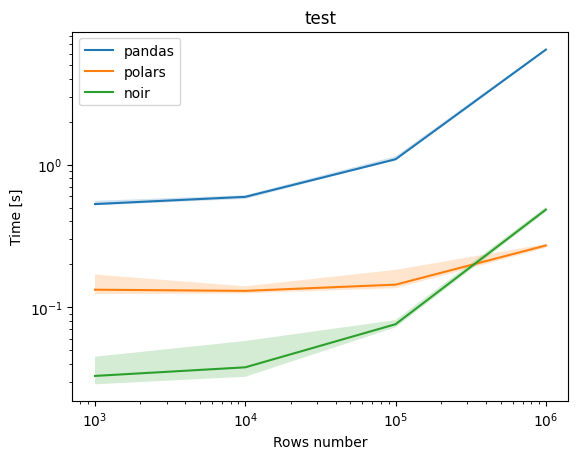

In [12]:
test1 = pd.read_csv('results/simple.csv')
plot_hyperfine_data(test1, 'test', variable='n_row')

In [ ]:
criterion = pd.read_csv('results/groupby_mean.csv')
join = pd.read_csv('results/join.csv')

plot_hyperfine_data(criterion, 'Groupby mean', variable='n_row')
plot_hyperfine_data(join, 'Join', variable='n_row')

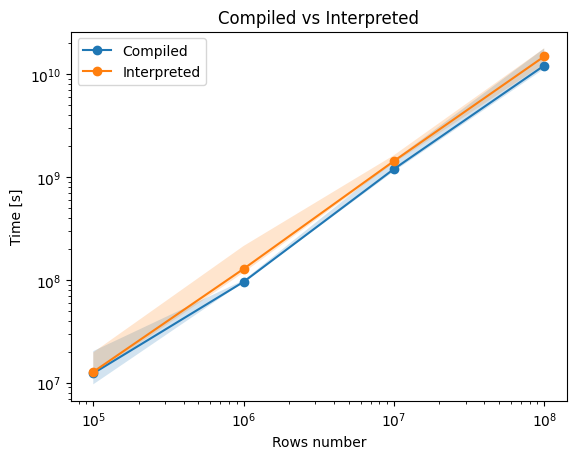

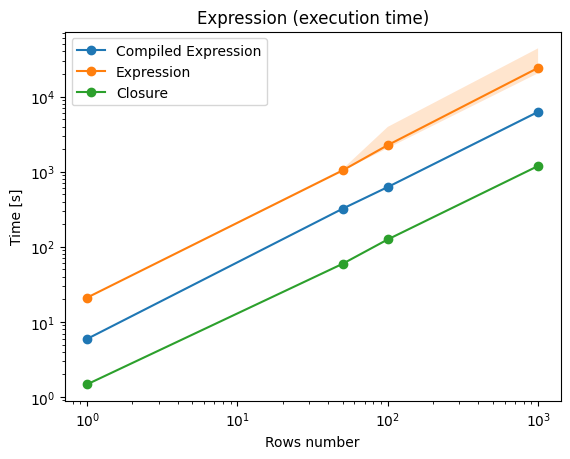

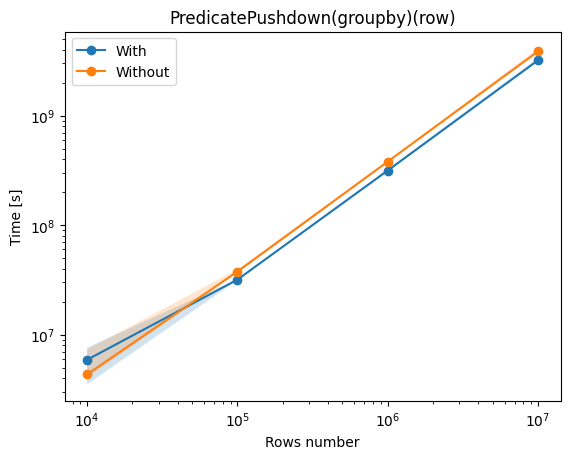

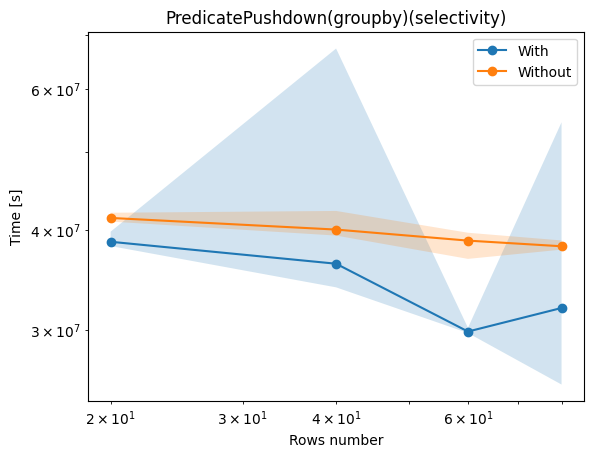

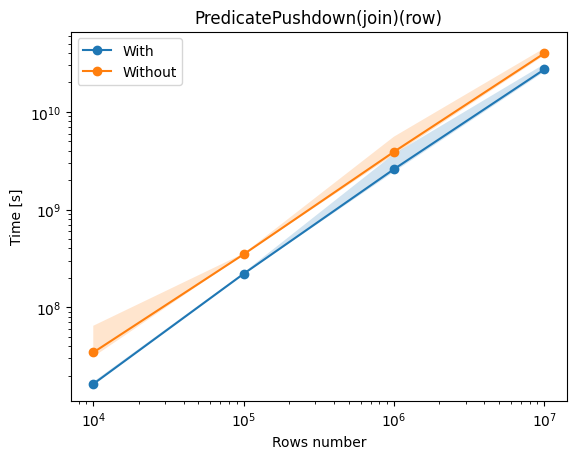

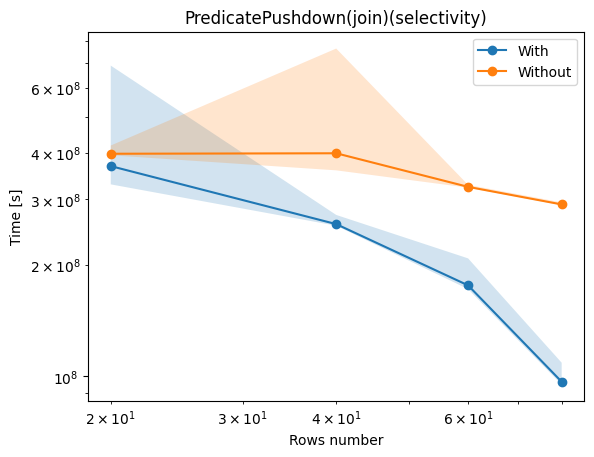

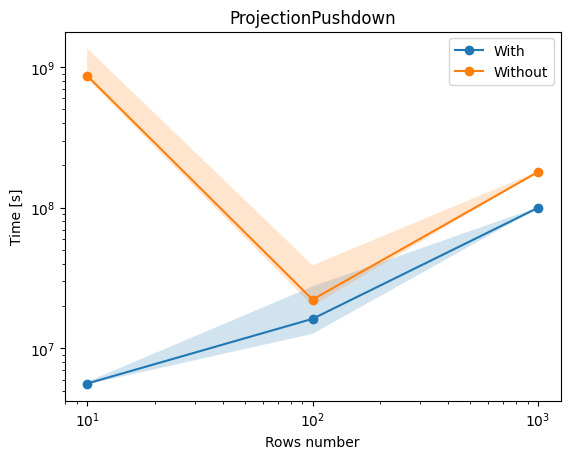

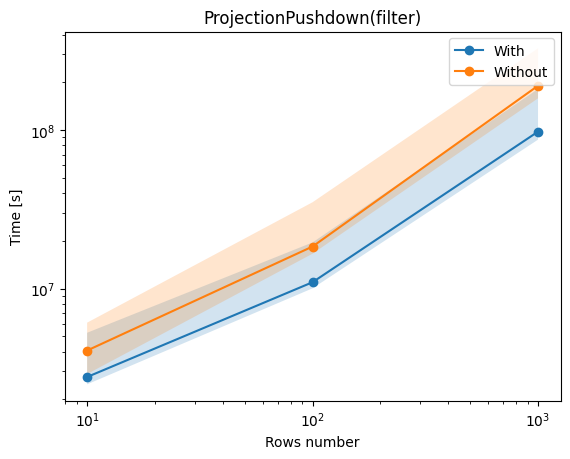

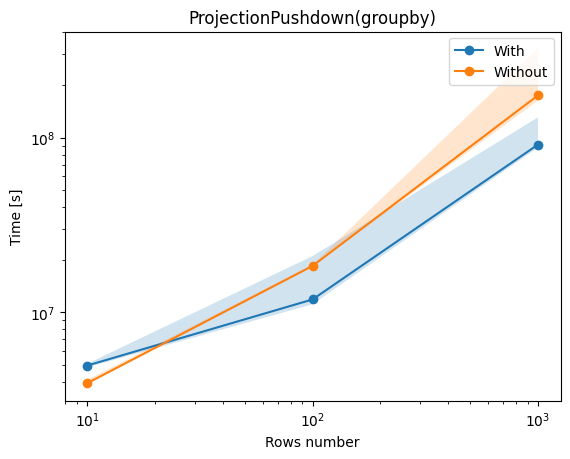

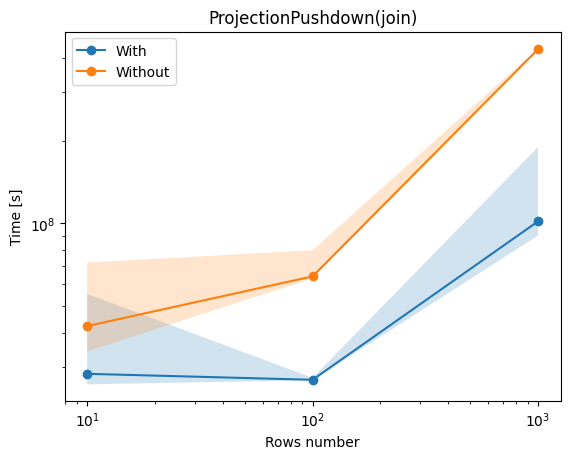

In [27]:
criterion = pd.read_csv('/home/fabio/Documents/Noir/py-evaluation/data@1709890444.csv').sort_values(by=['group', 'input'])

for group_name in criterion['group'].unique():
    group = criterion[criterion['group'] == group_name]
    plot_criterion_data(group, group_name)

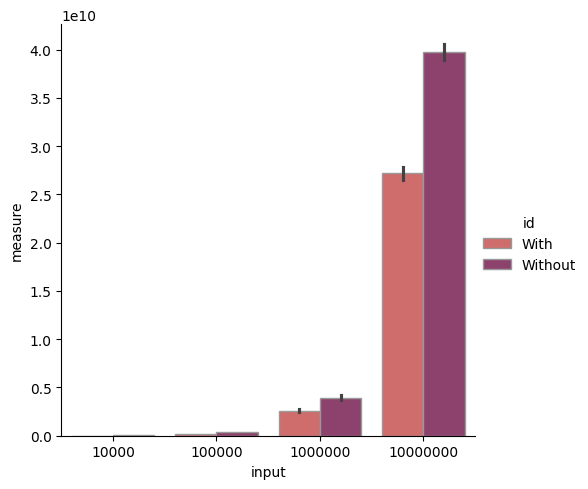

In [52]:
def criterion_boxplot(data, title):
    sns.catplot(data=data, x='input', y='measure', hue='id',
                palette='flare', edgecolor='.6', kind='bar')

data = pd.read_csv('/home/fabio/Documents/Noir/py-evaluation/data2@1709912108.csv').sort_values(by=['group', 'input'])
proj_pd_join = data[data['group'] == 'PredicatePushdown(join)(row)']
criterion_boxplot(proj_pd_join, 'Projection pushdown join')